## UNIVERSIDAD AUTÓNOMA DE CHIHUAHUA
#### FACULTAD DE INGENIERÍA
#### MIC 2 MACHINE LEARNING
#### Implementación de SVM: Phishing URLs
Maritrini Velázquez Ruiz 329675

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report

##Exploración de los Datos
Revisar campos vacios y rellenarlos con la media, correlación entre características, eliminación de "argPathRatio", codificación de los campos categoricos y estandarización de los datos numéricos

In [4]:
#Lectura del dataframe
url_data = pd.read_csv('urls.csv')

In [5]:
url_data

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
0,0,2,12,5.500000,8,4.083334,2,15,7,0,...,-1,-1,-1,0.676804,0.860529,-1.000000,-1.000000,-1.00000,-1.000000,benign
1,0,3,12,5.000000,10,3.583333,3,12,8,2,...,1,0,-1,0.715629,0.776796,0.693127,0.738315,1.00000,-1.000000,benign
2,2,2,11,4.000000,5,4.750000,2,16,11,0,...,2,0,1,0.677701,1.000000,0.677704,0.916667,0.00000,0.898227,benign
3,0,2,7,4.500000,7,5.714286,2,15,10,0,...,0,0,-1,0.696067,0.879588,0.818007,0.753585,0.00000,-1.000000,benign
4,19,2,10,6.000000,9,2.250000,2,9,5,0,...,5,4,3,0.747202,0.833700,0.655459,0.829535,0.83615,0.823008,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15362,0,2,3,8.000000,13,3.333333,2,3,2,0,...,0,0,-1,0.797046,0.884870,0.750000,1.000000,0.00000,-1.000000,phishing
15363,0,3,0,9.000000,16,NaN,3,0,0,0,...,-1,-1,-1,0.797564,0.813569,-1.000000,-1.000000,-1.00000,-1.000000,phishing
15364,0,3,2,6.666666,10,3.000000,3,3,2,0,...,0,0,-1,0.791104,0.801139,NaN,1.000000,0.00000,-1.000000,phishing
15365,0,2,3,8.000000,13,3.333333,2,4,2,0,...,0,0,-1,0.716580,0.787659,0.871049,1.000000,0.00000,-1.000000,phishing


In [6]:
#Información del conjunto de datos, revisar que cracterísticas tienen campos nulos
url_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15367 entries, 0 to 15366
Data columns (total 80 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Querylength                      15367 non-null  int64  
 1   domain_token_count               15367 non-null  int64  
 2   path_token_count                 15367 non-null  int64  
 3   avgdomaintokenlen                15367 non-null  float64
 4   longdomaintokenlen               15367 non-null  int64  
 5   avgpathtokenlen                  15096 non-null  float64
 6   tld                              15367 non-null  int64  
 7   charcompvowels                   15367 non-null  int64  
 8   charcompace                      15367 non-null  int64  
 9   ldl_url                          15367 non-null  int64  
 10  ldl_domain                       15367 non-null  int64  
 11  ldl_path                         15367 non-null  int64  
 12  ldl_filename      

In [7]:
url_data.shape

(15367, 80)

In [8]:
url_data.isnull().sum()

,0
Querylength,0
domain_token_count,0
path_token_count,0
avgdomaintokenlen,0
longdomaintokenlen,0
...,...
Entropy_DirectoryName,1826
Entropy_Filename,190
Entropy_Extension,3
Entropy_Afterpath,3


In [9]:
#Rellenar los datos vacios con la media
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean') #default 'mean'

In [10]:
#se realiza una extracción de los datos numéricos para realizar la transformación con el imputer
url_data_num = url_data.select_dtypes(include=[np.number]).columns
url_data_cat = url_data.select_dtypes(exclude=[np.number]).columns

In [11]:
numeric_url = url_data[url_data_num]
numeric_url.replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_imputed = pd.DataFrame(imputer.fit_transform(numeric_url), columns=url_data_num)

<ipython-input-11-d3cd408ce602>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_url.replace([np.inf, -np.inf], np.nan, inplace=True)


In [12]:
categorical_data = url_data[url_data_cat].reset_index(drop=True)

In [13]:
url_imputed_df = pd.concat([numeric_imputed, categorical_data], axis=1)

In [14]:
url_imputed_df

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
0,0.0,2.0,12.0,5.500000,8.0,4.083334,2.0,15.0,7.0,0.0,...,-1.0,-1.0,-1.0,0.676804,0.860529,-1.000000,-1.000000,-1.00000,-1.000000,benign
1,0.0,3.0,12.0,5.000000,10.0,3.583333,3.0,12.0,8.0,2.0,...,1.0,0.0,-1.0,0.715629,0.776796,0.693127,0.738315,1.00000,-1.000000,benign
2,2.0,2.0,11.0,4.000000,5.0,4.750000,2.0,16.0,11.0,0.0,...,2.0,0.0,1.0,0.677701,1.000000,0.677704,0.916667,0.00000,0.898227,benign
3,0.0,2.0,7.0,4.500000,7.0,5.714286,2.0,15.0,10.0,0.0,...,0.0,0.0,-1.0,0.696067,0.879588,0.818007,0.753585,0.00000,-1.000000,benign
4,19.0,2.0,10.0,6.000000,9.0,2.250000,2.0,9.0,5.0,0.0,...,5.0,4.0,3.0,0.747202,0.833700,0.655459,0.829535,0.83615,0.823008,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15362,0.0,2.0,3.0,8.000000,13.0,3.333333,2.0,3.0,2.0,0.0,...,0.0,0.0,-1.0,0.797046,0.884870,0.750000,1.000000,0.00000,-1.000000,phishing
15363,0.0,3.0,0.0,9.000000,16.0,5.289936,3.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,0.797564,0.813569,-1.000000,-1.000000,-1.00000,-1.000000,phishing
15364,0.0,3.0,2.0,6.666666,10.0,3.000000,3.0,3.0,2.0,0.0,...,0.0,0.0,-1.0,0.791104,0.801139,0.634859,1.000000,0.00000,-1.000000,phishing
15365,0.0,2.0,3.0,8.000000,13.0,3.333333,2.0,4.0,2.0,0.0,...,0.0,0.0,-1.0,0.716580,0.787659,0.871049,1.000000,0.00000,-1.000000,phishing


In [15]:
url_imputed_df.isnull().sum()

,0
Querylength,0
domain_token_count,0
path_token_count,0
avgdomaintokenlen,0
longdomaintokenlen,0
...,...
Entropy_DirectoryName,0
Entropy_Filename,0
Entropy_Extension,0
Entropy_Afterpath,0


In [16]:
#Conteo de URLs benignas y de phishing
url_imputed_df['URL_Type_obf_Type'].value_counts()

,count
URL_Type_obf_Type,
benign,7781
phishing,7586


<ipython-input-18-e5ea618fb6e7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='URL_Type_obf_Type', data=url_imputed_df,palette='hls')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='URL_Type_obf_Type', ylabel='count'>

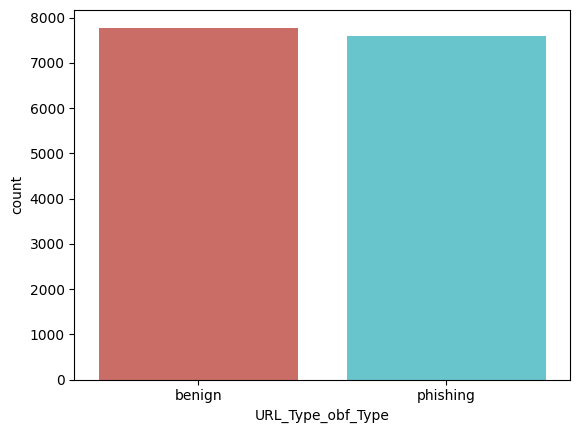

In [18]:
#Conteo de la etiqueta target
sns.countplot(x='URL_Type_obf_Type', data=url_imputed_df,palette='hls')

In [19]:
#Codificar con label encoding el target 'URL_Type_obf_Type' 0 para bening 1 para phishing
labelEn = LabelEncoder()

In [20]:
labelEn.fit(url_imputed_df['URL_Type_obf_Type'])

LabelEncoder()

In [21]:
url_imputed_df['URL_Type_obf_Type'] = labelEn.transform(url_imputed_df['URL_Type_obf_Type'])

In [23]:
url_imputed_df

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
0,0.0,2.0,12.0,5.500000,8.0,4.083334,2.0,15.0,7.0,0.0,...,-1.0,-1.0,-1.0,0.676804,0.860529,-1.000000,-1.000000,-1.00000,-1.000000,0
1,0.0,3.0,12.0,5.000000,10.0,3.583333,3.0,12.0,8.0,2.0,...,1.0,0.0,-1.0,0.715629,0.776796,0.693127,0.738315,1.00000,-1.000000,0
2,2.0,2.0,11.0,4.000000,5.0,4.750000,2.0,16.0,11.0,0.0,...,2.0,0.0,1.0,0.677701,1.000000,0.677704,0.916667,0.00000,0.898227,0
3,0.0,2.0,7.0,4.500000,7.0,5.714286,2.0,15.0,10.0,0.0,...,0.0,0.0,-1.0,0.696067,0.879588,0.818007,0.753585,0.00000,-1.000000,0
4,19.0,2.0,10.0,6.000000,9.0,2.250000,2.0,9.0,5.0,0.0,...,5.0,4.0,3.0,0.747202,0.833700,0.655459,0.829535,0.83615,0.823008,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15362,0.0,2.0,3.0,8.000000,13.0,3.333333,2.0,3.0,2.0,0.0,...,0.0,0.0,-1.0,0.797046,0.884870,0.750000,1.000000,0.00000,-1.000000,1
15363,0.0,3.0,0.0,9.000000,16.0,5.289936,3.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,0.797564,0.813569,-1.000000,-1.000000,-1.00000,-1.000000,1
15364,0.0,3.0,2.0,6.666666,10.0,3.000000,3.0,3.0,2.0,0.0,...,0.0,0.0,-1.0,0.791104,0.801139,0.634859,1.000000,0.00000,-1.000000,1
15365,0.0,2.0,3.0,8.000000,13.0,3.333333,2.0,4.0,2.0,0.0,...,0.0,0.0,-1.0,0.716580,0.787659,0.871049,1.000000,0.00000,-1.000000,1


In [24]:
#Se elimina la característica argPathRatio
url_imputed_df = url_imputed_df.drop(['argPathRatio'], axis=1)

In [25]:
##correlation matrix
corr_matrix = url_imputed_df.corr()
corr_matrix["URL_Type_obf_Type"].sort_values(ascending=False)

,URL_Type_obf_Type
URL_Type_obf_Type,1.000000
domainUrlRatio,0.575217
tld,0.493899
domain_token_count,0.493899
SymbolCount_Domain,0.493899
...,...
path_token_count,-0.452085
pathDomainRatio,-0.470423
delimeter_path,-0.522306
pathurlRatio,-0.556790


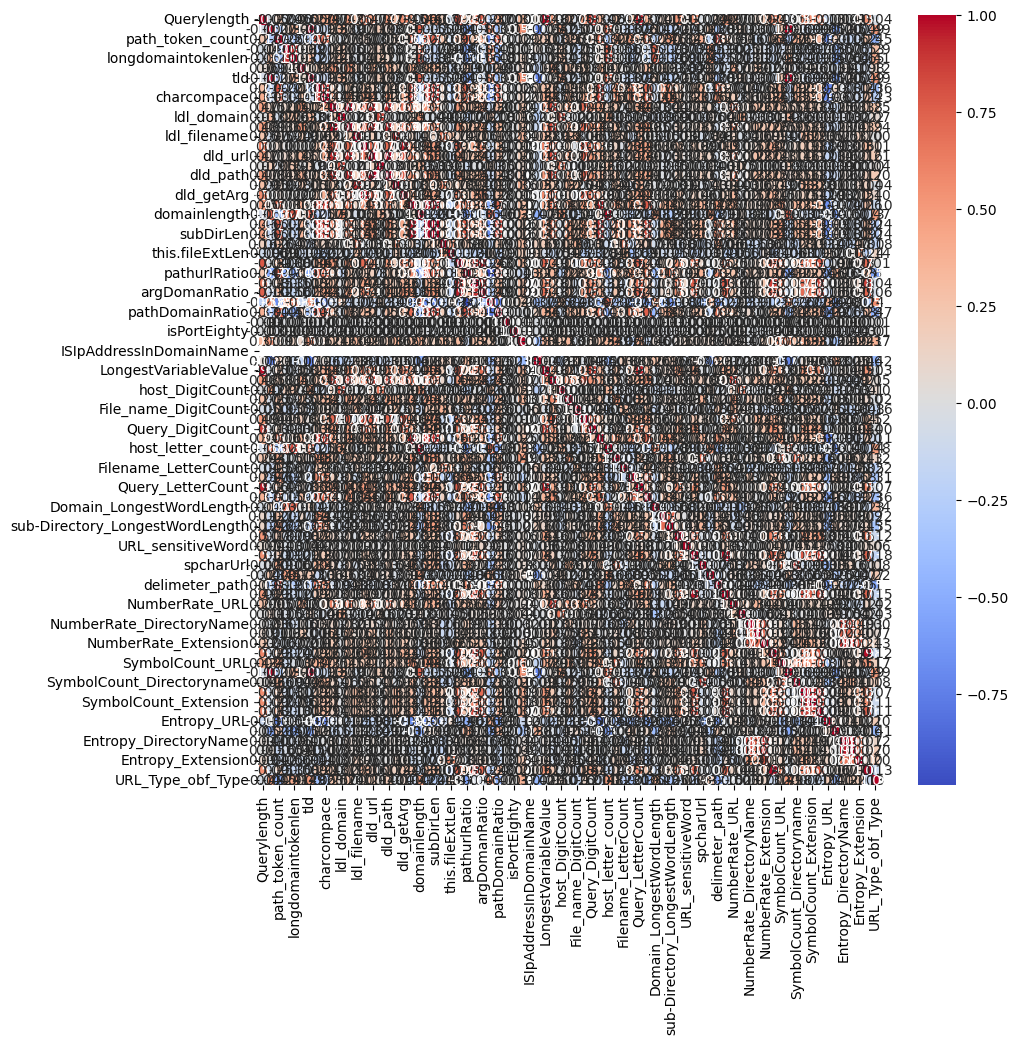

In [26]:
#matriz de correlaciones con el target
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot= True ,fmt=".2f", cmap='coolwarm', cbar=True)

plt.show()

In [28]:
#Separación de las características numericas y categoricas para el entrenamiento y prueba
X = url_imputed_df.drop(['URL_Type_obf_Type'], axis=1) #url_imputed_df['URL_Type_obf_Type']
X

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath
0,0.0,2.0,12.0,5.500000,8.0,4.083334,2.0,15.0,7.0,0.0,...,-1.0,-1.0,-1.0,-1.0,0.676804,0.860529,-1.000000,-1.000000,-1.00000,-1.000000
1,0.0,3.0,12.0,5.000000,10.0,3.583333,3.0,12.0,8.0,2.0,...,2.0,1.0,0.0,-1.0,0.715629,0.776796,0.693127,0.738315,1.00000,-1.000000
2,2.0,2.0,11.0,4.000000,5.0,4.750000,2.0,16.0,11.0,0.0,...,4.0,2.0,0.0,1.0,0.677701,1.000000,0.677704,0.916667,0.00000,0.898227
3,0.0,2.0,7.0,4.500000,7.0,5.714286,2.0,15.0,10.0,0.0,...,2.0,0.0,0.0,-1.0,0.696067,0.879588,0.818007,0.753585,0.00000,-1.000000
4,19.0,2.0,10.0,6.000000,9.0,2.250000,2.0,9.0,5.0,0.0,...,1.0,5.0,4.0,3.0,0.747202,0.833700,0.655459,0.829535,0.83615,0.823008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15362,0.0,2.0,3.0,8.000000,13.0,3.333333,2.0,3.0,2.0,0.0,...,1.0,0.0,0.0,-1.0,0.797046,0.884870,0.750000,1.000000,0.00000,-1.000000
15363,0.0,3.0,0.0,9.000000,16.0,5.289936,3.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,0.797564,0.813569,-1.000000,-1.000000,-1.00000,-1.000000
15364,0.0,3.0,2.0,6.666666,10.0,3.000000,3.0,3.0,2.0,0.0,...,-1.0,0.0,0.0,-1.0,0.791104,0.801139,0.634859,1.000000,0.00000,-1.000000
15365,0.0,2.0,3.0,8.000000,13.0,3.333333,2.0,4.0,2.0,0.0,...,1.0,0.0,0.0,-1.0,0.716580,0.787659,0.871049,1.000000,0.00000,-1.000000


In [29]:
y = url_imputed_df['URL_Type_obf_Type']
y

,URL_Type_obf_Type
0,0
1,0
2,0
3,0
4,0
...,...
15362,1
15363,1
15364,1
15365,1


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


<Axes: title={'center': 'Correlation with target '}>

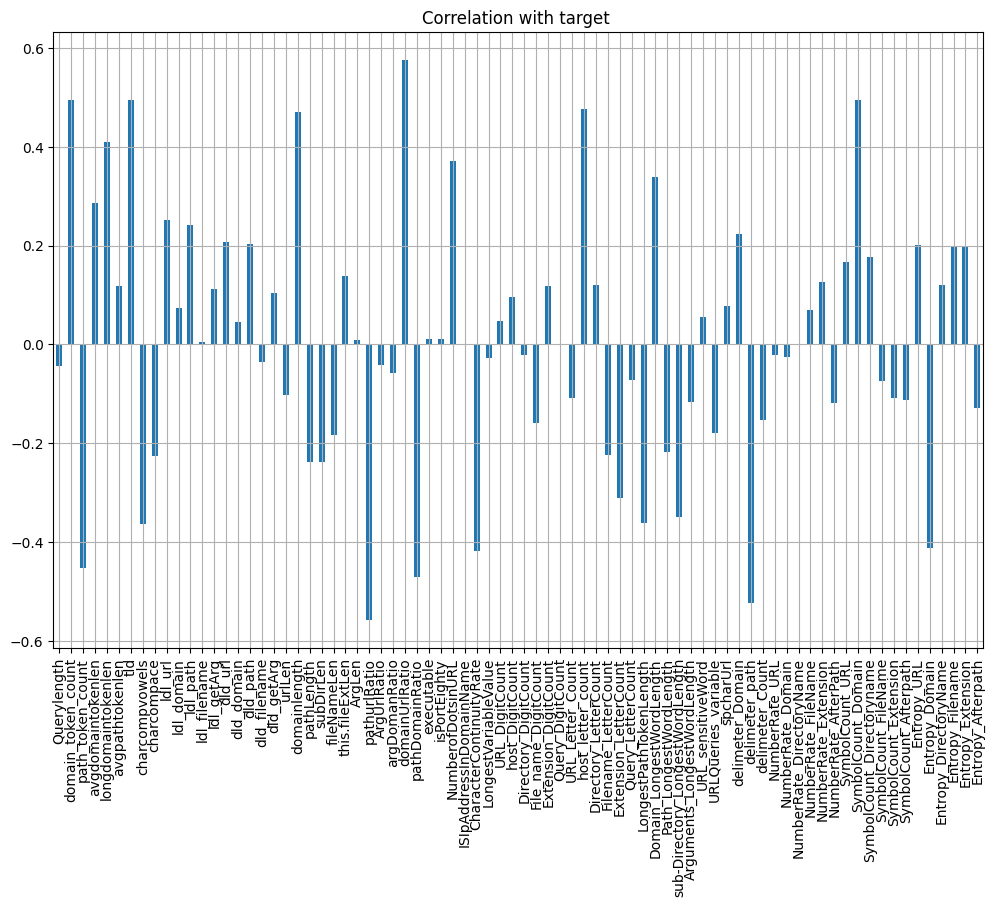

In [30]:
X.corrwith(y).plot(kind='bar', grid=True, figsize=(12, 8), title="Correlation with target ")

In [31]:
#escalamiento de los datos
scaler = StandardScaler()
X_standard = scaler.fit_transform(X)

In [32]:
X_standard

array([[-0.24351794, -0.57539808,  0.75597954, ..., -3.3714749 ,
        -2.27728542, -0.42512958],
       [-0.24351794,  0.4829074 ,  0.75597954, ...,  0.11102617,
         1.18991183, -0.42512958],
       [-0.1021851 , -0.57539808,  0.54139178, ...,  0.46833128,
        -0.5436868 ,  2.49656422],
       ...,
       [-0.24351794,  0.4829074 , -1.38989807, ...,  0.63527938,
        -0.5436868 , -0.42512958],
       [-0.24351794, -0.57539808, -1.17531031, ...,  0.63527938,
        -0.5436868 , -0.42512958],
       [-0.24351794, -0.57539808, -1.17531031, ...,  0.63527938,
         1.18991183, -0.42512958]])

In [33]:
#división de train y test 80/20
X_train, X_test, y_train, y_test = train_test_split(X_standard, y, test_size=0.2, random_state=42, stratify=y)

##Implementación de los modelos de SVM


*   SVM con Kernel Lineal
*   SVM con Kernel Polinomial
*   SVM con Kernel Gaussiano

Obtener métricas correspondientes (accuracy, precision, recall, fscore) y matriz de confusión

Para encontrar el mejor valor para los parámetros de los modelos puede usar el GridSearch o RandomSearch.



In [34]:
#SVM con Kernel Lineal
from sklearn.svm import LinearSVC
linearSCV_clf = LinearSVC(random_state=42, C=1.0, loss='hinge')
linearSCV_clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(loss='hinge', random_state=42)

In [35]:
y_pred = linearSCV_clf.predict(X_test)

In [36]:
accuracy_score(y_test, y_pred)

0.9616135328562134

In [37]:
precision_score(y_test, y_pred)

0.9654025282767797

In [38]:
f1_score(y_test, y_pred)

0.9609271523178808

In [39]:
recall_score(y_test, y_pred)

0.956493078444298

In [40]:
print("Classification Report: \n", classification_report(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      1557
           1       0.97      0.96      0.96      1517

    accuracy                           0.96      3074
   macro avg       0.96      0.96      0.96      3074
weighted avg       0.96      0.96      0.96      3074



In [41]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[1505   52]
 [  66 1451]]


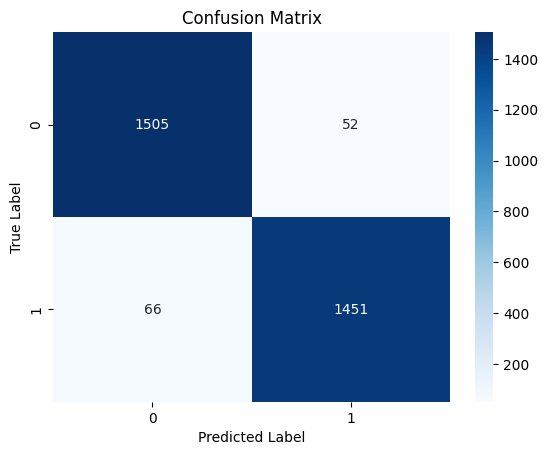

In [42]:

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [43]:
#Grid Search para LinearSVC
param_grid = {'C': [0.1, 1, 10, 100], 'loss': ['hinge', 'squared_hinge'] , 'penalty': ['l1', 'l2']}
grid_search = GridSearchCV(LinearSVC(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

GridSearchCV(cv=5, estimator=LinearSVC(random_state=42),
             param_grid={'C': [0.1, 1, 10, 100],
                         'loss': ['hinge', 'squared_hinge'],
                         'penalty': ['l1', 'l2']})

In [44]:
print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'C': 10, 'loss': 'hinge', 'penalty': 'l2'}


In [45]:
#evaluar con los mejores parametros
best_linear_clf = grid_search.best_estimator_
y_pred_grid_linear = best_linear_clf.predict(X_test)

In [82]:
best_linear_clf

LinearSVC(C=10, loss='hinge', random_state=42)

In [46]:
accuracy_score(y_test, y_pred_grid_linear)

0.9655172413793104

In [47]:
precision_score(y_test, y_pred_grid_linear)

0.9687707641196013

In [48]:
f1_score(y_test, y_pred_grid_linear)

0.9649238914626076

In [49]:
recall_score(y_test, y_pred_grid_linear)

0.9611074489123269

In [50]:
print("Classification Report: \n", classification_report(y_test, y_pred_grid_linear))

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      1557
           1       0.97      0.96      0.96      1517

    accuracy                           0.97      3074
   macro avg       0.97      0.97      0.97      3074
weighted avg       0.97      0.97      0.97      3074



In [51]:
conf_matrix = confusion_matrix(y_test, y_pred_grid_linear)
print(conf_matrix)

[[1510   47]
 [  59 1458]]


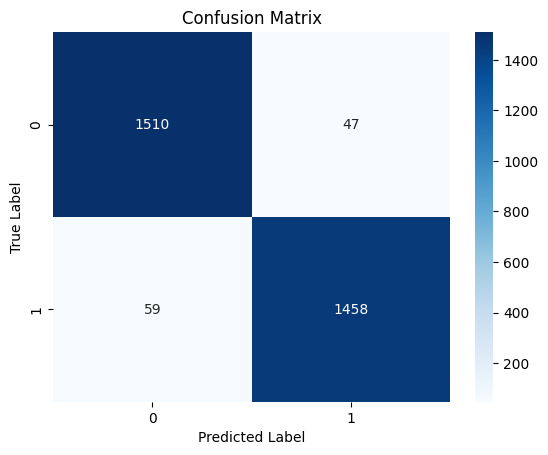

In [52]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [53]:
#SVM con kernel polinomial
from sklearn.svm import SVC
poly_clf = SVC(kernel='poly', degree=3, coef0=1, C=5)
poly_clf.fit(X_train, y_train)

SVC(C=5, coef0=1, kernel='poly')

In [54]:
#evaluacion
predict_poly = poly_clf.predict(X_test)

In [55]:
accuracy_score(y_test, predict_poly)

0.9830839297332465

In [56]:
precision_score(y_test, predict_poly)

0.984137475214805

In [57]:
recall_score(y_test, predict_poly)

0.981542518127884

In [58]:
f1_score(y_test, predict_poly)

0.9828382838283828

In [59]:
print("Classification Report: \n", classification_report(y_test, predict_poly))

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1557
           1       0.98      0.98      0.98      1517

    accuracy                           0.98      3074
   macro avg       0.98      0.98      0.98      3074
weighted avg       0.98      0.98      0.98      3074



In [60]:
conf_matrix = confusion_matrix(y_test, predict_poly)
print(conf_matrix)

[[1533   24]
 [  28 1489]]


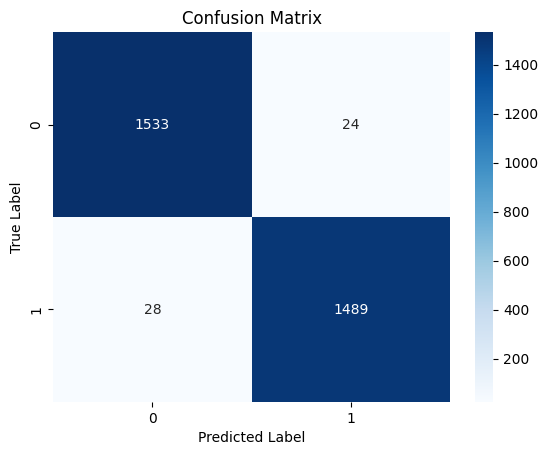

In [61]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [62]:
#grid search
param_grid = {'C': [0.1,1.0,5.0,10.0,100.0], 'degree': [2,3,4], 'coef0': [0.0,0.5,1.0]}
grid_search_poly = GridSearchCV(SVC(kernel='poly'), param_grid, cv=5)
grid_search_poly.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(kernel='poly'),
             param_grid={'C': [0.1, 1.0, 5.0, 10.0, 100.0],
                         'coef0': [0.0, 0.5, 1.0], 'degree': [2, 3, 4]})

In [63]:
print("Mejores parámetros:", grid_search_poly.best_params_)

Mejores parámetros: {'C': 10.0, 'coef0': 0.5, 'degree': 2}


In [64]:
#evaluar mejores parametros
best_poly_clf = grid_search_poly.best_estimator_
y_pred_grid_poly = best_poly_clf.predict(X_test)

In [81]:
grid_search_poly

GridSearchCV(cv=5, estimator=SVC(kernel='poly'),
             param_grid={'C': [0.1, 1.0, 5.0, 10.0, 100.0],
                         'coef0': [0.0, 0.5, 1.0], 'degree': [2, 3, 4]})

In [65]:
accuracy_score(y_test, y_pred_grid_poly)

0.9827586206896551

In [66]:
precision_score(y_test, y_pred_grid_poly)

0.9854111405835544

In [67]:
recall_score(y_test, y_pred_grid_poly)

0.979564930784443

In [68]:
f1_score(y_test, y_pred_grid_poly)

0.9824793388429752

In [69]:
print("Classification Report: \n", classification_report(y_test, y_pred_grid_poly))

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1557
           1       0.99      0.98      0.98      1517

    accuracy                           0.98      3074
   macro avg       0.98      0.98      0.98      3074
weighted avg       0.98      0.98      0.98      3074



In [70]:
conf_matrix = confusion_matrix(y_test, y_pred_grid_poly)
print(conf_matrix)

[[1535   22]
 [  31 1486]]


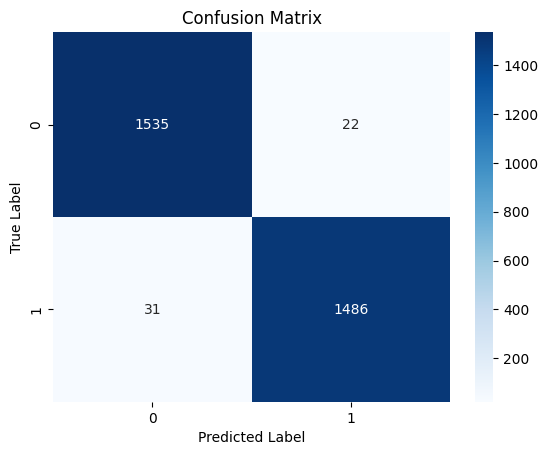

In [71]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [72]:
#SVM con kernel Gaussiano
rbf_clf = SVC(kernel='rbf', gamma=0.1, C=10)
rbf_clf.fit(X_train, y_train)

SVC(C=10, gamma=0.1)

In [73]:
#predicciones
predict_rbf = rbf_clf.predict(X_test)

In [74]:
accuracy_score(y_test, predict_rbf)

0.9769030579050098

In [75]:
precision_score(y_test, predict_rbf)

0.9688715953307393

In [76]:
recall_score(y_test, predict_rbf)

0.984838497033619

In [77]:
f1_score(y_test, predict_rbf)

0.9767898005884276

In [78]:
print("Classification Report: \n", classification_report(y_test, predict_rbf))

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      1557
           1       0.97      0.98      0.98      1517

    accuracy                           0.98      3074
   macro avg       0.98      0.98      0.98      3074
weighted avg       0.98      0.98      0.98      3074



In [79]:
conf_matrix = confusion_matrix(y_test, predict_rbf)
print(conf_matrix)

[[1509   48]
 [  23 1494]]


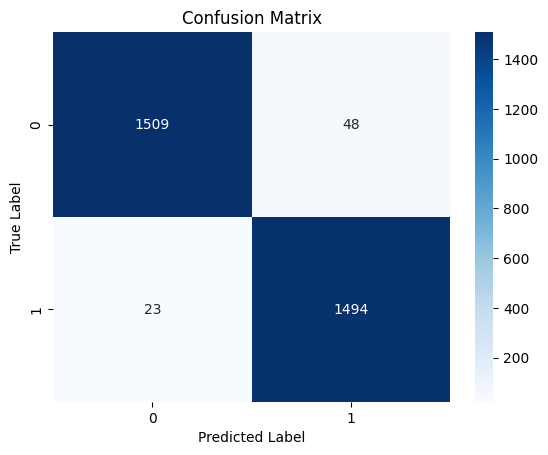

In [80]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [85]:
#grid search kernel gaussiano
param_grid = {'C':[0.01,0.1,1.0,10.0,100.0],'gamma':[0.1,1.0,5.0,10.0,100.0]}
grid_search_rbf = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)
grid_search_rbf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                         'gamma': [0.1, 1.0, 5.0, 10.0, 100.0]})

In [86]:
print("Mejores parámetros:", grid_search_rbf.best_params_)

Mejores parámetros: {'C': 10.0, 'gamma': 0.1}


In [87]:
#evaluar mejores parametros
best_rbf_clf = grid_search_rbf.best_estimator_
y_pred_grid_rbf = best_rbf_clf.predict(X_test)

In [88]:
accuracy_score(y_test, y_pred_grid_rbf)

0.9769030579050098

In [89]:
precision_score(y_test, y_pred_grid_rbf)

0.9688715953307393

In [90]:
recall_score(y_test, y_pred_grid_rbf)

0.984838497033619

In [91]:
f1_score(y_test, y_pred_grid_rbf)

0.9767898005884276

In [92]:
print("Classification Report: \n", classification_report(y_test, y_pred_grid_rbf))

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      1557
           1       0.97      0.98      0.98      1517

    accuracy                           0.98      3074
   macro avg       0.98      0.98      0.98      3074
weighted avg       0.98      0.98      0.98      3074



In [93]:
conf_matrix = confusion_matrix(y_test, y_pred_grid_rbf)
print(conf_matrix)

[[1509   48]
 [  23 1494]]


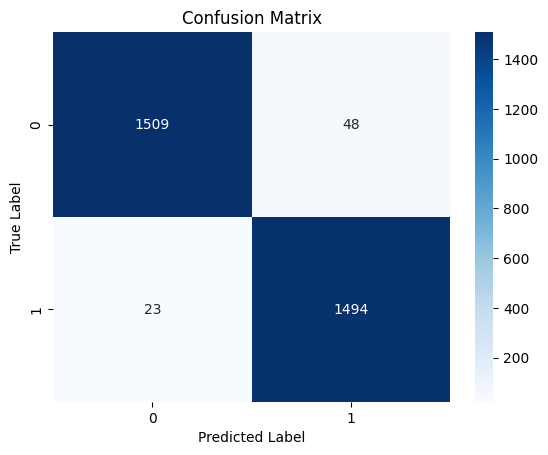

In [94]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

##Análisis de Resultados
El SVM lineal obtuvo un accuracy del 96.55% con sus mejores hiperparámetros, el de kernel polinomial un 98.2% y el kernel gaussiano un 97.69%. COmo este problema tiene bastantes features para clasificar una url como buena o maliciosa, podria resolverse mejor usando el SVC con kernel polinomial. El kernel polinomial de grado 2 es suficiente para captar las relaciones no lineales importantes entre los datos sin sobreajustarse. Además tiene una capacidad de complejidad intermedia, lo cual podría haber resultado en un buen equilibrio entre ajustar los datos de entrenamiento y generalizar adecuadamente a los datos de prueba, especialmente si la relación no lineal es sencilla.